In [110]:
import pickle

# 从文件中加载变量
with open("./data22_plus_amount.pkl", 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
# 组合训练集和测试集的数据
X_train_data = X_train
y_train_data = y_train
X_test_data = X_test
y_test_data = y_test

In [111]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# 假设MyDataset已定义并能正确读取X, y数据
dataset_train = MyDataset(X_train_data, y_train_data)
dataset_test = MyDataset(X_test_data, y_test_data)
# 创建DataLoader实例
batch_size = 128
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True, dropout_rate=0.5):
        super(EnhancedGRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), hidden_size), # Adjust input size if bidirectional
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )
        self.layer_norm = nn.LayerNorm(hidden_size * (2 if bidirectional else 1))

    def forward(self, x):
        # Initialize the hidden state for GRU
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # GRU forward pass
        out, _ = self.gru(x, h0)

        # Apply Layer Normalization
        out = self.layer_norm(out[:, -1, :])

        # Pass through fully connected layers
        out = self.fc_layers(out)
        return out



In [113]:
# 定义模型超参数
hidden_size = 80
num_layers = 3
num_epochs = 5
dropout_rate = 0.5  # 设置dropout率 
learning_rate = 0.0002  # 设置学习率 
bidirection = True
weight_decay = 0.01

In [114]:
input_size = 6
output_size = 2

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 实例化模型
model = EnhancedGRUClassifier(input_size, hidden_size, num_layers, output_size, bidirection, dropout_rate).to('cuda')

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [116]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def train():
    # 用于记录整个训练过程的损失和准确率
    epoch_losses = []
    epoch_accuracies = []
    # 训练模型 
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0
        for i, (batch_X, batch_y) in enumerate(dataloader_train):
            # Forward pass
            batch_X = batch_X.to('cuda')
            batch_y = batch_y.to('cuda')
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            # 每20个batch报告一次
            if (i + 1) % 2000 == 0:
                current_loss = total_loss / (i + 1)
                current_accuracy = correct / total
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch {i+1}, Loss: {current_loss:.6f}, Accuracy: {current_accuracy:.4f}')
        
        # 计算每个epoch的平均损失和准确率
        average_loss = total_loss / len(dataloader_train)
        accuracy = correct / total
        epoch_losses.append(average_loss)
        epoch_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.6f}, Accuracy: {accuracy:.4f}')
    # 绘制损失和准确率图表
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), epoch_accuracies, marker='o')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def test():
    total_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    # 使用model.eval()将模型切换到评估模式
    model.eval()

    with torch.no_grad():  # 禁用梯度计算
        for i, (batch_X, batch_y) in enumerate(dataloader_test):
            batch_X = batch_X.to('cuda')
            batch_y = batch_y.to('cuda')
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    # 计算整个测试集的平均损失和准确率
    average_loss = total_loss / len(dataloader_test)
    accuracy = correct / total
    
    print(f'Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')
    # 计算混淆矩阵、精确率和召回率
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("Precision:", precision)
    print("Recall:", recall)
    
    # 绘制热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Epoch [1/5], Batch 2000, Loss: 0.688337, Accuracy: 0.5147
Epoch [1/5], Batch 4000, Loss: 0.686951, Accuracy: 0.5159
Epoch [1/5], Batch 6000, Loss: 0.686460, Accuracy: 0.5166
Epoch [1/5], Batch 8000, Loss: 0.686120, Accuracy: 0.5178
Epoch [1/5], Batch 10000, Loss: 0.685878, Accuracy: 0.5190
Epoch [1/5], Average Loss: 0.685756, Accuracy: 0.5196
Epoch [2/5], Batch 2000, Loss: 0.683977, Accuracy: 0.5326
Epoch [2/5], Batch 4000, Loss: 0.683711, Accuracy: 0.5355
Epoch [2/5], Batch 6000, Loss: 0.683554, Accuracy: 0.5364
Epoch [2/5], Batch 8000, Loss: 0.683420, Accuracy: 0.5374
Epoch [2/5], Batch 10000, Loss: 0.683211, Accuracy: 0.5384
Epoch [2/5], Average Loss: 0.683096, Accuracy: 0.5389
Epoch [3/5], Batch 2000, Loss: 0.681878, Accuracy: 0.5442
Epoch [3/5], Batch 4000, Loss: 0.681552, Accuracy: 0.5456
Epoch [3/5], Batch 6000, Loss: 0.681393, Accuracy: 0.5460
Epoch [3/5], Batch 8000, Loss: 0.681209, Accuracy: 0.5468
Epoch [3/5], Batch 10000, Loss: 0.681014, Accuracy: 0.5474
Epoch [3/5], Averag

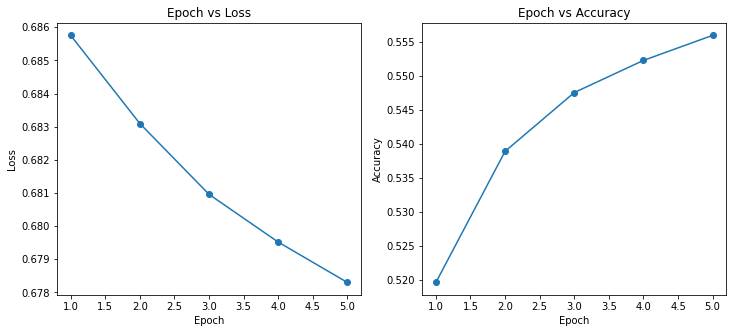

In [118]:
train()

Average Loss: 0.6784, Accuracy: 0.5428
Confusion Matrix:
[[216158  40751]
 [185270  52211]]
Precision: 0.5616380886813968
Recall: 0.21985337774390373


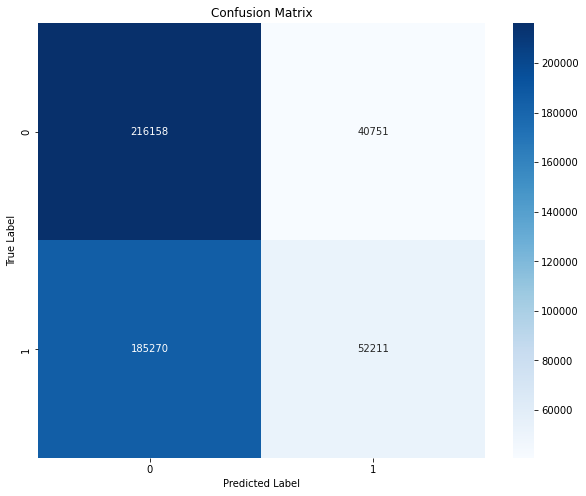

In [119]:
test()

In [120]:
print(model)

EnhancedGRUClassifier(
  (gru): GRU(6, 80, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=160, out_features=80, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=80, out_features=2, bias=True)
  )
  (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
)
